In [1]:
from src.utils import *
from src.plots import *

In [2]:
p = r'/Users/jquinnlee/Desktop/georepca1/georepca1'
os.chdir(p)

In [3]:
animals = ['QLAK-CA1-08', 'QLAK-CA1-30', 'QLAK-CA1-50', 'QLAK-CA1-51', 'QLAK-CA1-56', 'QLAK-CA1-74', 'QLAK-CA1-75']

##
##### Optionally convert original matlab files to joblib files (large) that can be loaded efficiently in Python
##### Subsequent calls of "format" in load_dat assume joblib format

In [4]:
for animal in tqdm(animals):
    mat2joblib(animal, p)

### Load in dataset from example animal

In [4]:
# Load third animal in dataset as example
animal = animals[2]
dat = load_dat(animal, p, format="joblib")

Loading preprocessed data for animal QLAK-CA1-50


## Figure 1C
### Plot example event rate maps from CA1 neurons across sessions in a geometric sequence


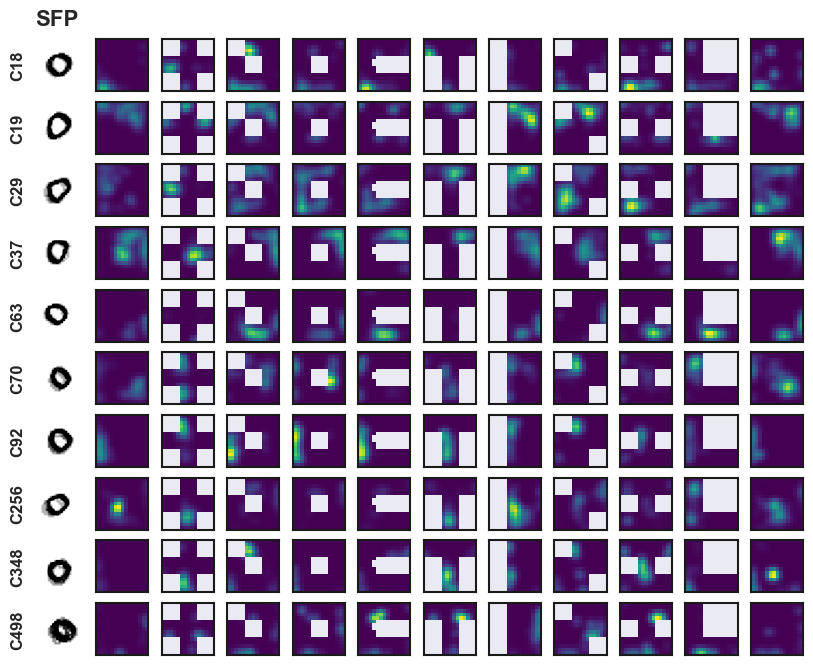

In [5]:
# Use example cells and sessions from paper
example_cells_idx = np.array([17, 18, 28, 36, 62, 69, 91, 255, 347, 497])
example_days_idx = np.arange(20, 31)
# Index example maps and create contours from spatial footprints ("SFPs")
example_maps = {"smoothed": dat[animal]["maps"]["smoothed"][:, :, example_cells_idx, :][:, :, :, example_days_idx]}
example_sfps = trace_sfps(dat[animal]['SFPs'])[:, :, example_cells_idx, :][:, :, :, example_days_idx]
plot_maps(example_maps, animal,  p, example_sfps, example_cells_idx, unsmoothed=False, cmap='viridis')


##
## Figure 1E-F Split half spatial reliability and Bayesian position decoding accuracy

In [20]:
# Calculate split-half spatial reliability for all recorded cells within each session
for animal in animals:
    dat = load_dat(animal, p, format="joblib")
    p_vals, _ = get_shr_within(dat, animal, nsims=10)
    joblib.dump(p_vals, os.path.join(p, "results", f"{animal}_shr"))

In [6]:
# fit bayesian decoder with flat priors to each day position within day (cross-validated)
# return decoding error (mean each day) for all animals and save to results folder
within_decoding = {}
for animal in animals:
    within_decoding[animal] = {}
    dat = load_dat(animal, p, format="joblib")
    within_decoding[animal]['envs'] = dat[animal]['envs'].squeeze()
    within_decoding[animal]['decoding_error'] = \
        decode_position_within(dat[animal]['position'].T, dat[animal]['trace'].T, dat[animal]['maps']['smoothed'])[0]
joblib.dump(within_decoding, os.path.join(p, "results", "within_decoding"))

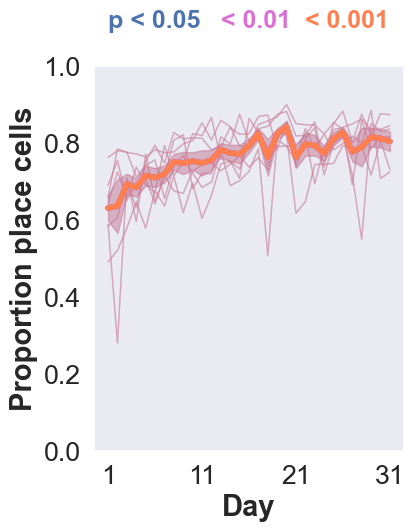

One-way ANOVA for SHR across days: 
               df       sum_sq   mean_sq          F         PR(>F)
C(Day)       30.0    37.398480  1.246616  33.209185  8.763364e-189
Residual  69713.0  2616.906818  0.037538        NaN            NaN


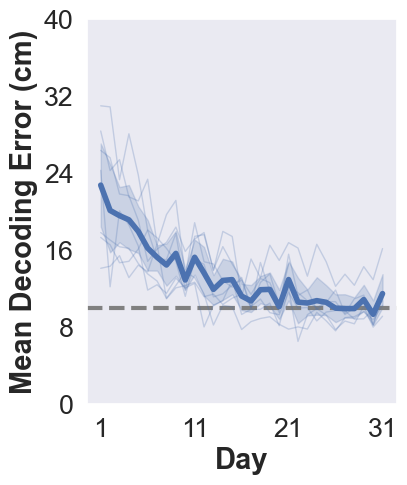

One-way ANOVA for decoding error across days: 
             df       sum_sq    mean_sq         F        PR(>F)
C(Day)     30.0  2492.695189  83.089840  7.984459  4.419462e-20
Residual  176.0  1831.534494  10.406446       NaN           NaN


In [4]:
# Load split-half reliability p values from all animals and all sessions into single dataframe
df_pvals = get_all_shr_pvals(animals, p)
# STATS One-way ANOVA
plot_shr_pvals(df_pvals)
formula = 'SHR ~ C(Day)'
lm = ols(formula, df_pvals).fit()
print(f"One-way ANOVA for SHR across days: \n{anova_lm(lm)}")
df_decoding = get_all_decoding_within(animals, p)
plot_decoding_within_days(df_decoding)
formula = 'Error ~ C(Day)'
lm = ols(formula, df_decoding).fit()
print(f"One-way ANOVA for decoding error across days: \n{anova_lm(lm)}")
# Plot SHR and decoding error across all recordings


##
## Figure 1H-I
### Rate map (whole/non-partitioned) representational similarity and nMDS embedding

In [14]:
# calculate the average map correlation across geometries, and plot as RSM and with non-metric MDS and dendrogram
mean_map_corr, _, labels, map_corr_animals_sequences = get_mean_map_corr(animals, p)
map_corr_dict = {"mean_map_corr": mean_map_corr,
                 "labels": labels,
                 "map_corr_animals_sequences": map_corr_animals_sequences}
joblib.dump(map_corr_dict, os.path.join(p, "results", "map_corr_envs"))
map_corr_dict = joblib.load(os.path.join(p, "results", "map_corr_envs"))
mean_map_corr, labels, map_corr_animals_sequences = map_corr_dict["mean_map_corr"], map_corr_dict["labels"], map_corr_dict["map_corr_animals_sequences"]

Loading preprocessed data for animal QLAK-CA1-08


Correlating ratemaps across days and cell pairs: 515it [00:34, 14.78it/s]


Loading preprocessed data for animal QLAK-CA1-30


Correlating ratemaps across days and cell pairs: 875it [01:07, 12.98it/s] 


Loading preprocessed data for animal QLAK-CA1-50


Correlating ratemaps across days and cell pairs: 942it [01:03, 14.77it/s] 


Loading preprocessed data for animal QLAK-CA1-51


Correlating ratemaps across days and cell pairs: 554it [00:16, 32.77it/s] 


Loading preprocessed data for animal QLAK-CA1-56


Correlating ratemaps across days and cell pairs: 862it [01:01, 14.03it/s] 


Loading preprocessed data for animal QLAK-CA1-74


Correlating ratemaps across days and cell pairs: 713it [00:48, 14.79it/s]


Loading preprocessed data for animal QLAK-CA1-75


Correlating ratemaps across days and cell pairs: 952it [01:00, 15.82it/s]


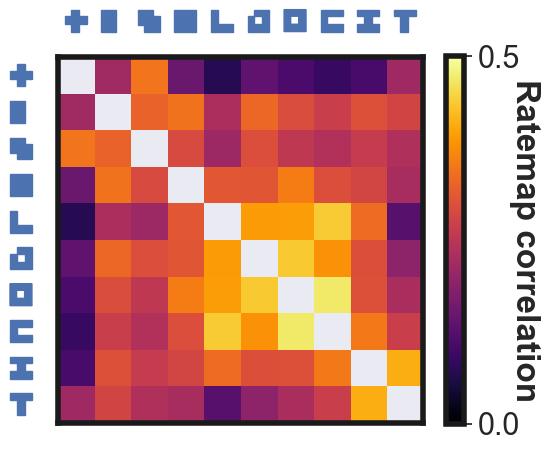

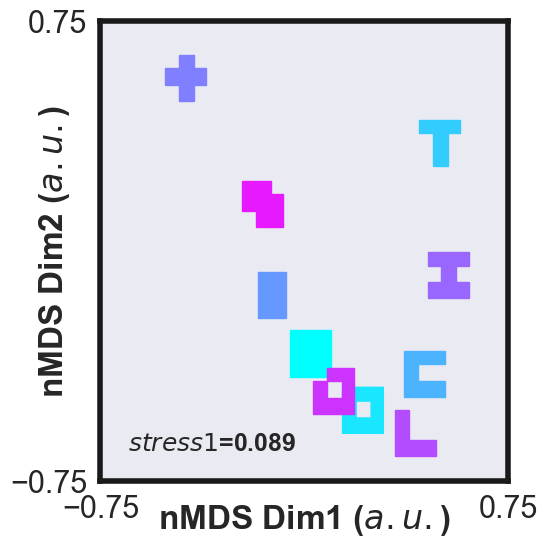

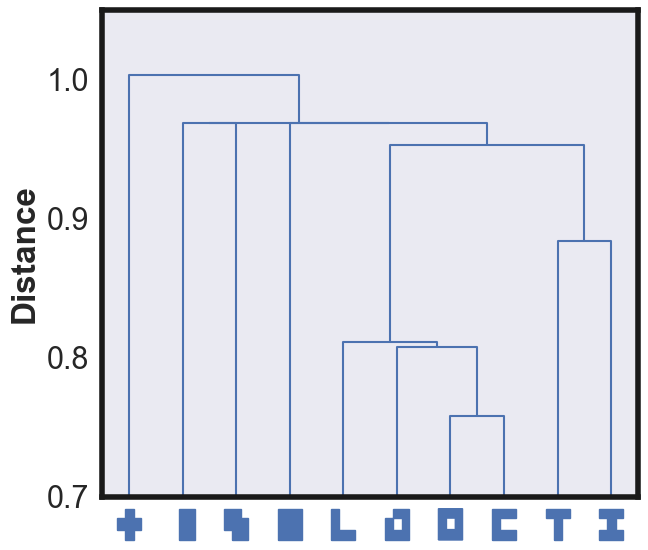

In [5]:
map_corr_envs = joblib.load(os.path.join(p, "results", "map_corr_envs"))
mean_map_corr, labels, map_corr_animals_sequences = map_corr_envs["mean_map_corr"], map_corr_envs["labels"], map_corr_envs["map_corr_animals_sequences"]

fig_h = plot_map_corr_rsm_ordered(mean_map_corr, labels)
fig_i = plot_map_corr_mds(mean_map_corr, labels)
fig_j = plot_map_corr_dendrogram(mean_map_corr, labels)

##
## Figure 1K
### Calculate similarity of representations across animals

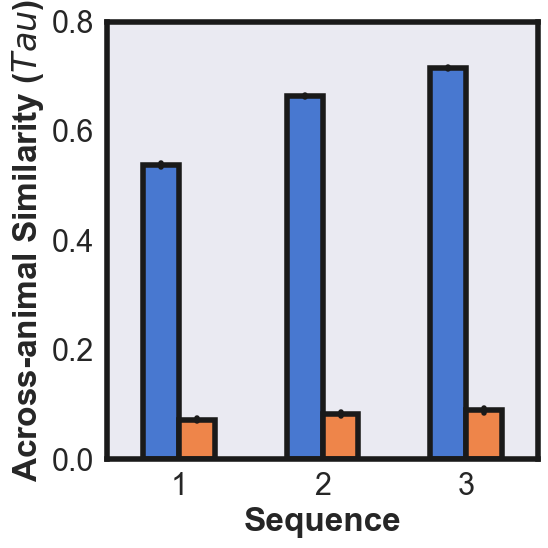

Two-way ANOVA for across-animal RSM similarity based on sequnece: 
                             df       sum_sq      mean_sq              F  \
C(Sequence)                 2.0    37.319981    18.659991    1679.225987   
C(Shuffle)                  1.0  1725.239284  1725.239284  155255.525214   
C(Sequence):C(Shuffle)      2.0    25.583175    12.791587    1151.124160   
Residual                22794.0   253.292784     0.011112            NaN   

                        PR(>F)  
C(Sequence)                0.0  
C(Shuffle)                 0.0  
C(Sequence):C(Shuffle)     0.0  
Residual                   NaN  


In [9]:
df_map_corr_animals_sequences = get_rsm_similarity_animals_sequences(animals, p)
fig_k = plot_across_animal_similarity(df_map_corr_animals_sequences)

# two-way ANOVA for effect of sequence and shuffle on across-animal remapping similarity (whole rate map)
formula = 'Fit ~ C(Sequence) + C(Shuffle) + C(Sequence):C(Shuffle)'
lm = ols(formula, df_map_corr_animals_sequences).fit()
print(f"Two-way ANOVA for across-animal RSM similarity based on sequnece: \n{anova_lm(lm)}")